In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from env import get_db_url

# Exercise

### Save this work in your ```anomaly-detection-exercises``` repository in a file named ```discrete_anomaly_detection.ipynb```.

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [4]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1) # the code '[1:]' grabs the letters after the bracket
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = get_db_url('logs')   
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])


In [6]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [9]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


In [10]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


## Count: 
The number of times each unique value appears in the dataset


In [13]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

## Frequencies: 
The number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [14]:
df.ip.value_counts(normalize=True).head()


97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

## We can define a function that combines both these pieces of information:

In [25]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True
    )

In [28]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.reset_index(inplace=True)
ip_df.rename(columns={'index': 'ip'}, inplace=True)

In [32]:
ip_df.head()

,ip,count,proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


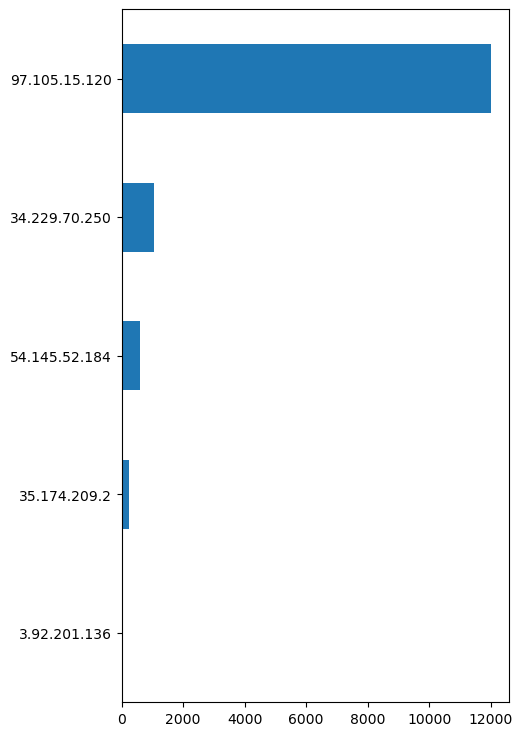

In [36]:


ax = ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

ip_values = ip_df.tail()['ip'].values

# Set y-axis tick labels using set_yticklabels
ax.set_yticklabels(ip_values)

# Show the plot
plt.show()


## Conditional Probabilities: 
Probabilities using 2 discrete variables


In [18]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


* Cases where the probability is < 100% -- this means that multiple different status codes were encountered from the given ip address
* Status codes other than 200. 200 is the most common response code in our dataset by far.

In [19]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [37]:
df


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [40]:
val_cnt_freq_dict = {}

def value_counts_and_frequencies(df):
    val_cnt_freq_dict = {}
    
    for col in df.columns:
        count_df = pd.merge(
            df[col].value_counts(dropna=False).rename('count'),
            df[col].value_counts(dropna=False, normalize=True).rename('proba'),
            left_index=True,
            right_index=True
        )
        val_cnt_freq_dict[col] = count_df
        
    return val_cnt_freq_dict

In [48]:
results_dict = value_counts_and_frequencies(df)

In [52]:
results_dict.keys()

dict_keys(['ip', 'request_method', 'request_path', 'http_version', 'status_code', 'size', 'user_agent', 'size_mb'])

In [65]:
# Create a function tpo produce probabilty of a and b
def proba_a_given_b(df, a_col, b_col):

    # create the dataframe
    a_given_b = (
        df.groupby(b_col)\
        [a_col].value_counts(normalize=True)\
        .rename(f'proba_{a_col}_given_{b_col}')\
        .reset_index())
    
    # return the variable
    return a_given_b

In [66]:
proba_a_given_b(df, 'request_path', 'ip')

,ip,request_path,proba_request_path_given_ip
0,173.173.113.51,/api/v1/items,0.060434
1,173.173.113.51,/api/v1/items?page=2,0.058546
2,173.173.113.51,/api/v1/items?page=3,0.058546
3,173.173.113.51,/api/v1/stores,0.050992
4,173.173.113.51,/api/v1/sales,0.007554
...,...,...,...
815,97.105.19.58,/api/v1/sales?page=79/,0.000083
816,97.105.19.58,/api/v1/stores?page=2,0.000083
817,97.105.19.58,/api/v1/stores?page=666,0.000083
818,97.105.19.58,/api/v1/stores?page=999,0.000083


In [69]:
# Create a function tpo produce probabilty of a and b
def proba_a_given_b_text(df, a_col, b_col):
    
    # return proba a and b
    proba_a_and_b = df.groupby([b_col, a_col]).size()/len(df)
    
    # return proba b
    proba_b = df.groupby(b_col).size()/len(df)
    
    return pd.DataFrame((proba_a_and_b / proba_b).sort_values(ascending=True))

In [70]:
proba_a_given_b_text(df, 'request_path', 'ip')

0
ip            request_path                                     
97.105.19.58  /api/v1/items?page=99999999999999999998  0.000083
              /api/v1//api/v1/items                    0.000083
              /api/v1//api/v1/items/next_page          0.000083
              /api/v1/I_DIDNT_DO_IT!!!!                0.000083
              /api/v1/helloclass!                      0.000083
...                                                         ...
52.91.30.150  /                                        1.000000
54.145.52.184 /favicon.ico                             1.000000
54.172.14.223 /api/v1/                                 1.000000
3.88.129.158  /api/v1/items                            1.000000
95.31.18.119  /api/v1/items/                           1.000000

[820 rows x 1 columns]